<h1><center><font size="6">Honye Bee Subspecies Classifications</font></center></h1>

<a>Load packages</a>



In [1]:
#Importing all the libraries we need 
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow

<a>The next two cells are to be run, only when mounting in google collab</a>



In [ ]:
# Mounting csv and image files from Google drive:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
# changing to the directory to the folder with the files  #to run, delete everything and run only this line, without notes
cd /content/drive/MyDrive/ColabNotebooks/CNN_project/ 

<a>Continue</a>



In [2]:
#For tensorflow, we will first need to define the variables we will be using later
#This is essentially the network structure and settings we are using later 

IMAGE_PATH = 'C:\\Users\\dnten\\Desktop\\Bellen\\bee_imgs\\bee_imgs\\'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 100 ##it affects accuracy we will be testing
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50
PATIENCE = 5
VERBOSE = 1


# <a id='22'>#Importing images and labels
</a>  


In [3]:
os.listdir("C:\\Users\\dnten\\Desktop\\Bellen") #directory

['.ipynb_checkpoints', 'bee_imgs', 'honey-bee-subspecies-classification.ipynb']

In [4]:
honey_bee_df=pd.read_csv('C:\\Users\\dnten\\Desktop\\Bellen\\bee_imgs\\bee_data.csv')#reading csv file with image names

In [5]:
honey_bee_df.shape #checking the shape

(5172, 9)

In [7]:
#We need to check if any of the data is missing or not, to make sure we have no holes
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(honey_bee_df)

,Total,Percent
file,0,0.0
date,0,0.0
time,0,0.0
location,0,0.0
zip code,0,0.0
subspecies,0,0.0
health,0,0.0
pollen_carrying,0,0.0
caste,0,0.0


In [8]:
#We now print the number of labels and number of images we have to make sure we dont have a missmatch

image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5173


In [9]:
file_names = list(honey_bee_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))
# print("Matching name-image pairs: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 5172


In [10]:
#Checking our data
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    return list(image.shape)

In [11]:
#Making a numpy array of the names and the labels, to be used for training
# sizes = np.stack(read_image_sizes(bee_dataframe['file']))m = np.stack(honey_bee_df['file'].apply(read_image_sizes))
m = np.stack(honey_bee_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c'])
honey_bee_df = pd.concat([honey_bee_df,df],axis=1, sort=False)


# <a id='11'>#Importing images
</a>  

In [12]:
traceW = go.Box(
    x = honey_bee_df['w'],
    name="Width",
     marker=dict(
                color='rgba(238,23,11,0.5)',
                line=dict(
                    color='red',
                    width=1.2),
            ),
    orientation='h')
traceH = go.Box(
    x = honey_bee_df['h'],
    name="Height",
    marker=dict(
                color='rgba(11,23,245,0.5)',
                line=dict(
                    color='blue',
                    width=1.2),
            ),
    orientation='h')
data = [traceW, traceH]
layout = dict(title = 'Width & Heights of images',
          xaxis = dict(title = 'Size', showticklabels=True), 
          yaxis = dict(title = 'Image dimmension'),
          hovermode = 'closest',
         )
fig = dict(data=data, layout=layout)
# iplot(fig, filename='width-height')


## <a id='34'>Ploting the subspecies distribution</a>   



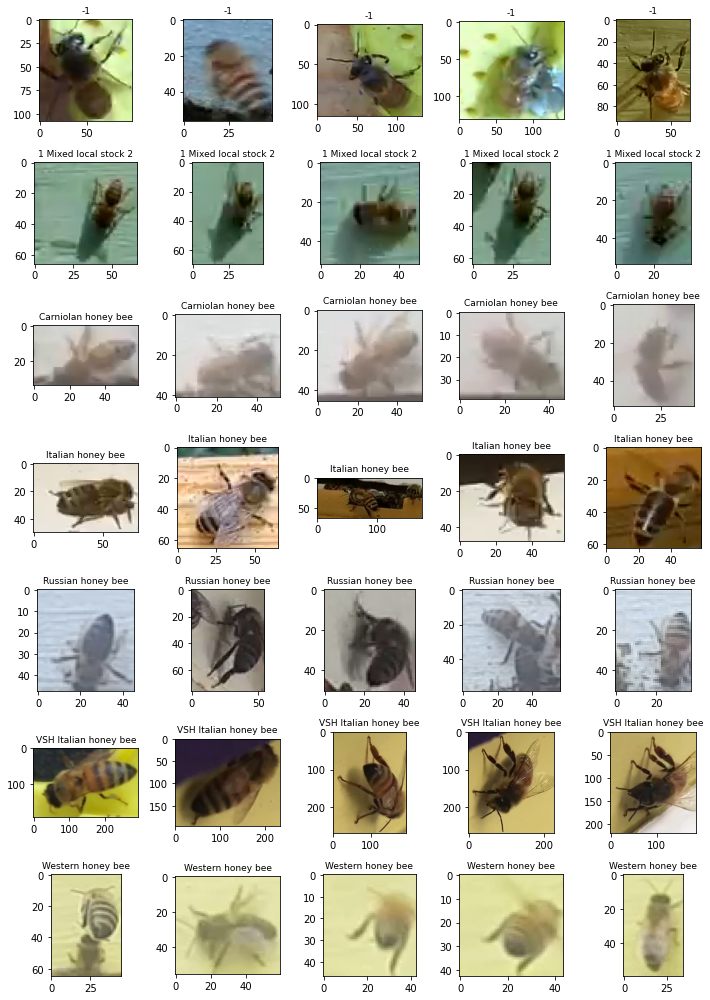

In [13]:
def draw_category_images(var,cols=5):
    categories = (honey_bee_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = honey_bee_df[honey_bee_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()
#seeing some subspecies
draw_category_images("subspecies")

### Subspecies and image size 

In [14]:
def draw_trace_box(dataset,var, subspecies):
    dfS = dataset[dataset['subspecies']==subspecies];
    trace = go.Box(
        x = dfS[var],
        name=subspecies,
        marker=dict(
                    line=dict(
                        color='black',
                        width=0.8),
                ),
        text=dfS['subspecies'], 
        orientation = 'h'
    )
    return trace

subspecies = (honey_bee_df.groupby(['subspecies'])['subspecies'].nunique()).index
def draw_group(dataset, var, title,height=500):
    data = list()
    for subs in subspecies:
        data.append(draw_trace_box(dataset, var, subs))
        
    layout = dict(title = title,
              xaxis = dict(title = 'Size',showticklabels=True),
              yaxis = dict(title = 'Subspecies', showticklabels=True, tickfont=dict(
                family='Old Standard TT, serif',
                size=8,
                color='black'),), 
              hovermode = 'closest',
              showlegend=False,
                  width=600,
                  height=height,
             )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='subspecies-image')


draw_group(honey_bee_df, 'w', "Width of images per subspecies")
draw_group(honey_bee_df, 'h', "Height of images per subspecies")

# <a id='4'>Subspecies classification</a>

## <a id='40'>Split the data</a>  

First, we split the whole dataset in train and test. We will use **random_state** to ensure reproductibility of results.   

The train-test split is **80%** for training set and **20%** for test set.


In [15]:
train_df, test_df = train_test_split(honey_bee_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, 
                                     stratify=honey_bee_df['subspecies'])

Next, we will split further the **train** set in **train** and **validation**. We want to use as well a validation set to be able to measure not only how well fits the model the train data during training (or how well `learns` the training data) but also how well the model is able to generalize so that we are able to understands not only the bias but also the variance of the model.  

The train-validation split is **80%** for training set and **20%** for validation set.

In [16]:
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=train_df['subspecies'])

#Checking their shape to make sure

In [17]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 3309
Test  set rows: 1035
Val   set rows: 828


## <a id='41'>Build a baseline model</a>    


Building a simple model to make sure our implementation works

In [18]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

A function to create the dummy variables corresponding to the categorical target variable.

In [19]:
def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

Populating the train, val and test sets

In [20]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

Model contains:
* One convolutional layer, with 16 filters of dimmension 3;  
* One maxpoll2d layer, with reduction factor 2;  
* One convolutional layer, with 16 filters of dimmension 3;  
* A flatten layer;  
* A dense layer;  

In [21]:
model1=Sequential()
model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 7)                 280007    
                                                                 
Total params: 282,775
Trainable params: 282,775
Non-trainable params: 0
__________________________________________________

Creating random variation of the training dataset, by applying the techniques described in the google docs:
* rotation (in a range of 0-180 degrees) of the original images;  
- zoom (10%);  
- shift in horizontal and in vertical direction (10%);  
- horizontal and vertical flip;  


In [23]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

We train the first model using **fit_generator** and a predefined batch size. The **steps_per_epoch** is calculated to be size of the training set divided by the batch size. We are using the predefined epoch number for this first experiment (5 steps) and as well validation, using the validation set. 

In [24]:
train_model1  = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=8,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)
#NO_EPOCHS_1 experimentally found to be 8, as optimal

C:\Users\dnten\AppData\Local\Temp\ipykernel_28556\2854461372.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/8
103/103 [==============================] - 21s 193ms/step - loss: 0.9765 - accuracy: 0.6609 - val_loss: 0.7555 - val_accuracy: 0.7331
Epoch 2/8
103/103 [==============================] - 19s 185ms/step - loss: 0.6576 - accuracy: 0.7528 - val_loss: 0.5559 - val_accuracy: 0.8019
Epoch 3/8
103/103 [==============================] - 18s 178ms/step - loss: 0.5766 - accuracy: 0.7767 - val_loss: 0.5188 - val_accuracy: 0.8176
Epoch 4/8
103/103 [==============================] - 19s 181ms/step - loss: 0.4473 - accuracy: 0.8338 - val_loss: 0.4622 - val_accuracy: 0.8043
Epoch 5/8
103/103 [==============================] - 21s 200ms/step - loss: 0.4243 - accuracy: 0.8426 - val_loss: 0.4559 - val_accuracy: 0.8382
Epoch 6/8
103/103 [==============================] - 23s 220ms/step - loss: 0.3386 - accuracy: 0.8722 - val_loss: 0.3089 - val_accuracy: 0.8768
Epoch 7/8
103/103 [==============================] - 22s 212ms/step - loss: 0.3509 - accuracy: 0.8555 - val_loss: 0.3761 - val_accuracy:

In [25]:
#Model works yayyy

## <a id='42'>Model evaluation</a> 

Plotting loss error for train and validation

In [26]:
#To be implemented


evaluating the **test** set **loss** and **accuracy**. Using the test set

In [27]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3567432463169098
Test accuracy: 0.8763285279273987


Accuracy per class

In [28]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [29]:
test_accuracy_report(model1)

33/33 [==============================] - 1s 39ms/step
                       precision    recall  f1-score   support

                   -1       0.80      0.71      0.75        86
1 Mixed local stock 2       0.73      0.38      0.50        94
  Carniolan honey bee       1.00      0.95      0.97       100
    Italian honey bee       0.86      0.96      0.91       602
    Russian honey bee       0.93      1.00      0.96       106
VSH Italian honey bee       1.00      0.57      0.73        40
    Western honey bee       1.00      1.00      1.00         7

             accuracy                           0.88      1035
            macro avg       0.90      0.80      0.83      1035
         weighted avg       0.87      0.88      0.87      1035

Loss function: 0.3567432463169098, accuracy: 0.8763285279273987


In [53]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model1)

## <a id='43'>Same model with dropout</a>  

Goals= reduce overfitting

In [30]:
model2=Sequential()
model2.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model2.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(y_train.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                      

Ouuu same number of parameters

In [32]:
train_model2  = model2.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

C:\Users\dnten\AppData\Local\Temp\ipykernel_28556\2538114789.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
103/103 [==============================] - 27s 254ms/step - loss: 0.9831 - accuracy: 0.6972 - val_loss: 0.7482 - val_accuracy: 0.6993
Epoch 2/10
103/103 [==============================] - 25s 245ms/step - loss: 0.6021 - accuracy: 0.7619 - val_loss: 0.5039 - val_accuracy: 0.8007
Epoch 3/10
103/103 [==============================] - 25s 243ms/step - loss: 0.4499 - accuracy: 0.8172 - val_loss: 0.5580 - val_accuracy: 0.7754
Epoch 4/10
103/103 [==============================] - 25s 244ms/step - loss: 0.3922 - accuracy: 0.8350 - val_loss: 0.4062 - val_accuracy: 0.8321
Epoch 5/10
103/103 [==============================] - 25s 242ms/step - loss: 0.3560 - accuracy: 0.8610 - val_loss: 0.4330 - val_accuracy: 0.8430
Epoch 6/10
103/103 [==============================] - 25s 246ms/step - loss: 0.3631 - accuracy: 0.8640 - val_loss: 0.5905 - val_accuracy: 0.7754
Epoch 7/10
103/103 [==============================] - 25s 243ms/step - loss: 0.3535 - accuracy: 0.8571 - val_loss: 0.3719 - val_ac

### Evaluate model accuracy and loss

In [134]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model2)

### Test accuracy and loss

Let's evaluare as well the test accuracy and loss.

In [34]:
test_accuracy_report(model2)

33/33 [==============================] - 1s 38ms/step
                       precision    recall  f1-score   support

                   -1       0.81      0.71      0.76        86
1 Mixed local stock 2       0.58      0.83      0.68        94
  Carniolan honey bee       0.96      0.95      0.95       100
    Italian honey bee       0.95      0.88      0.91       602
    Russian honey bee       0.91      0.98      0.95       106
VSH Italian honey bee       0.78      0.90      0.84        40
    Western honey bee       1.00      0.86      0.92         7

             accuracy                           0.88      1035
            macro avg       0.86      0.87      0.86      1035
         weighted avg       0.89      0.88      0.88      1035

Loss function: 0.3017124533653259, accuracy: 0.8792270421981812



## <a id='45'>Changing sum stuff to see what happaaaan</a>  




In [35]:
annealer3 = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+NO_EPOCHS_3))
earlystopper3 = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer3 = ModelCheckpoint('best_model_3.h5',
                                monitor='val_acc',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [36]:
model3=Sequential()
model3.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model3.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model3.add(Dropout(0.4))
model3.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(Dense(y_train.columns.size, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 dropout_3 (Dropout)         (None, 50, 50, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                      

Training the model

In [38]:
train_model3  = model3.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_3,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE,
                        callbacks=[earlystopper3, checkpointer3, annealer3])

C:\Users\dnten\AppData\Local\Temp\ipykernel_28556\2443815439.py:1: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
103/103 [==============================] - 27s 247ms/step - loss: 1.2475 - accuracy: 0.6292 - val_loss: 0.9073 - val_accuracy: 0.7065 - lr: 7.7831e-04
Epoch 2/50
103/103 [==============================] - 26s 255ms/step - loss: 0.7257 - accuracy: 0.7507 - val_loss: 0.8034 - val_accuracy: 0.6606 - lr: 7.7442e-04
Epoch 3/50
103/103 [==============================] - 26s 248ms/step - loss: 0.5629 - accuracy: 0.7821 - val_loss: 0.5770 - val_accuracy: 0.7633 - lr: 7.7055e-04
Epoch 4/50
103/103 [==============================] - 29s 275ms/step - loss: 0.5015 - accuracy: 0.8042 - val_loss: 0.4660 - val_accuracy: 0.8116 - lr: 7.6670e-04
Epoch 5/50
103/103 [==============================] - 26s 250ms/step - loss: 0.4160 - accuracy: 0.8341 - val_loss: 0.6277 - val_accuracy: 0.7621 - lr: 7.6286e-04
Epoch 6/50
103/103 [==============================] - 25s 244ms/step - loss: 0.3865 - accuracy: 0.8429 - val_loss: 0.3509 - val_accuracy: 0.8478 - lr: 7.5905e-04
Epoch 7/50
103/103 [========

103/103 [==============================] - 25s 238ms/step - loss: 0.2481 - accuracy: 0.8994 - val_loss: 0.3606 - val_accuracy: 0.8587 - lr: 6.8664e-04
Epoch 27/50
103/103 [==============================] - 25s 239ms/step - loss: 0.2287 - accuracy: 0.9006 - val_loss: 0.2699 - val_accuracy: 0.8913 - lr: 6.8321e-04
Epoch 28/50
103/103 [==============================] - 26s 251ms/step - loss: 0.2535 - accuracy: 0.8912 - val_loss: 0.2744 - val_accuracy: 0.8877 - lr: 6.7979e-04
Epoch 29/50
103/103 [==============================] - 34s 328ms/step - loss: 0.2442 - accuracy: 0.8991 - val_loss: 0.2211 - val_accuracy: 0.9118 - lr: 6.7639e-04
Epoch 30/50
103/103 [==============================] - 25s 238ms/step - loss: 0.2309 - accuracy: 0.9018 - val_loss: 0.2216 - val_accuracy: 0.8998 - lr: 6.7301e-04
Epoch 31/50
103/103 [==============================] - 25s 236ms/step - loss: 0.2254 - accuracy: 0.9000 - val_loss: 0.2733 - val_accuracy: 0.8949 - lr: 6.6965e-04
Epoch 32/50
103/103 [=============

### Model accuracy and loss

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/conv2d_4/Relu' defined at (most recent call last):
    File "C:\Users\dnten\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\dnten\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\dnten\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\dnten\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\dnten\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\dnten\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\dnten\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\dnten\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\dnten\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\dnten\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "C:\Users\dnten\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "C:\Users\dnten\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "C:\Users\dnten\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "C:\Users\dnten\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\dnten\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "C:\Users\dnten\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "C:\Users\dnten\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\dnten\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\dnten\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\dnten\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\dnten\AppData\Local\Temp\ipykernel_28556\3665405525.py", line 19, in <cell line: 19>
      draw_category_images("subspecies")
    File "C:\Users\dnten\AppData\Local\Temp\ipykernel_28556\3665405525.py", line 10, in draw_category_images
      print(model3.predict(image))
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\dnten\anaconda3\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_2/conv2d_4/Relu'
input must be 4-dimensional[32,100,3]
	 [[{{node sequential_2/conv2d_4/Relu}}]] [Op:__inference_predict_function_39300]

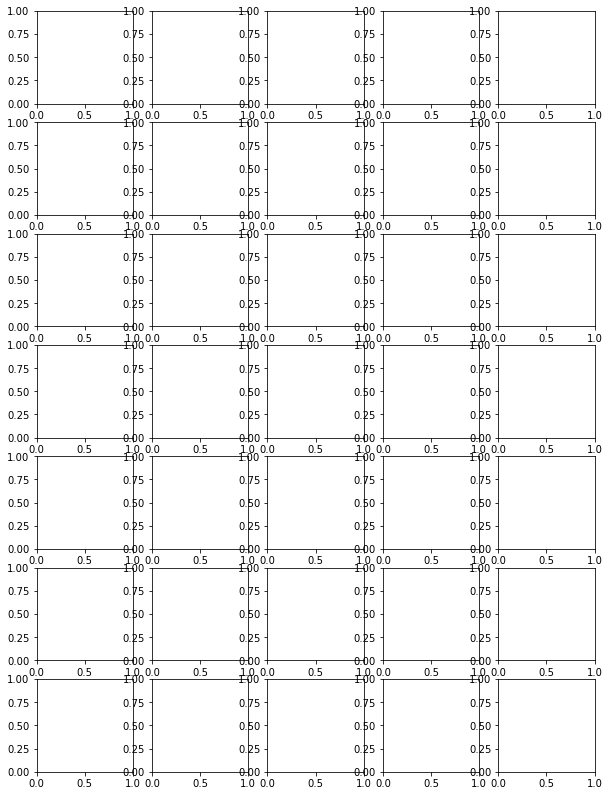

In [133]:
def draw_category_images(var,cols=5):
    categories = (honey_bee_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = honey_bee_df[honey_bee_df[var]==cat].sample(cols)
    image=sample.iloc[0]['file']
    image=read_image(image)
    print(model3.predict(image))
#     print("******************************************")
#         for j in range(0,cols):
#             file=IMAGE_PATH + sample.iloc[j]['file']
#             im=imageio.imread(file)
#             ax[i, j].imshow(im, resample=True)
#             ax[i, j].set_title(cat, fontsize=9)  
#     plt.tight_layout()
#     plt.show()
#seeing some subspecies
draw_category_images("subspecies")

In [52]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model3)

### Test accuracy and loss

In [40]:
test_accuracy_report(model3)

33/33 [==============================] - 2s 57ms/step
                       precision    recall  f1-score   support

                   -1       0.95      0.88      0.92        86
1 Mixed local stock 2       0.77      0.82      0.79        94
  Carniolan honey bee       0.98      0.99      0.99       100
    Italian honey bee       0.95      0.95      0.95       602
    Russian honey bee       0.95      1.00      0.97       106
VSH Italian honey bee       0.94      0.85      0.89        40
    Western honey bee       1.00      0.86      0.92         7

             accuracy                           0.94      1035
            macro avg       0.93      0.91      0.92      1035
         weighted avg       0.94      0.94      0.94      1035

Loss function: 0.1978837549686432, accuracy: 0.9371980428695679
